In [1]:
%reload_ext autoreload
%autoreload 2
import json
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from pyeed import Pyeed
import matplotlib.pyplot as plt
import itertools
from scipy.spatial.distance import pdist, squareform

/home/nab/anaconda3/envs/pyeed_niklas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SetUp

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()  # Load variables from .env
password = os.getenv("NEO4J_NIKLAS_JUST_TEMS")
if password is None:
    raise ValueError("KEY is not set in the .env file.")

In [3]:
uri = "bolt://127.0.0.1:1123"
user = "neo4j"

eedb = Pyeed(uri, user=user, password=password)

📡 Connected to database.


In [4]:
# read in the pandas dataframe
df = pd.read_csv('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_lactamase.csv', sep=';')
print(df.head())

# df.to_csv('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_lactamase.csv', sep=';', index=False)

  protein_name phenotype    protein_id protein_id_database
0        TEM-1        2b      AAP20891          AAP20891.1
1        TEM-2        2b      CAJ85677          CAJ85677.1
2        TEM-3       2be      SAQ02853          SAQ02853.1
3        TEM-4       2be      CDR98216          CDR98216.1
4        TEM-5       2be  WP_109963600      WP_109963600.1


In [5]:
ids = df['protein_id_database'].dropna().tolist()
labels = df['phenotype'].tolist()

# pd.nan should be None
labels = [None if pd.isna(x) else x for x in labels]

dict_id_label = {}
for i in range(len(ids)):
    dict_id_label[ids[i]] = labels[i]

print(len(ids))
print(len(labels))

209
265


In [6]:
# we now load the previously saved distance matrix and protein ids
distance_matrix_embeddings_cosine = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_cosine.npy")
distance_matrix_embeddings_euclidean = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_euclidean.npy")
protein_ids_embedding = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_embedding.npy")

distance_matrix_pairwise = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_pairwise_default_methode.npy")
protein_ids_pairwise = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_pairwise_default_methode.npy")

distance_matrix_mutations = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_mutations.npy")
protein_ids_mutations = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_mutations.npy")

# Disprove TSNE Algorithm

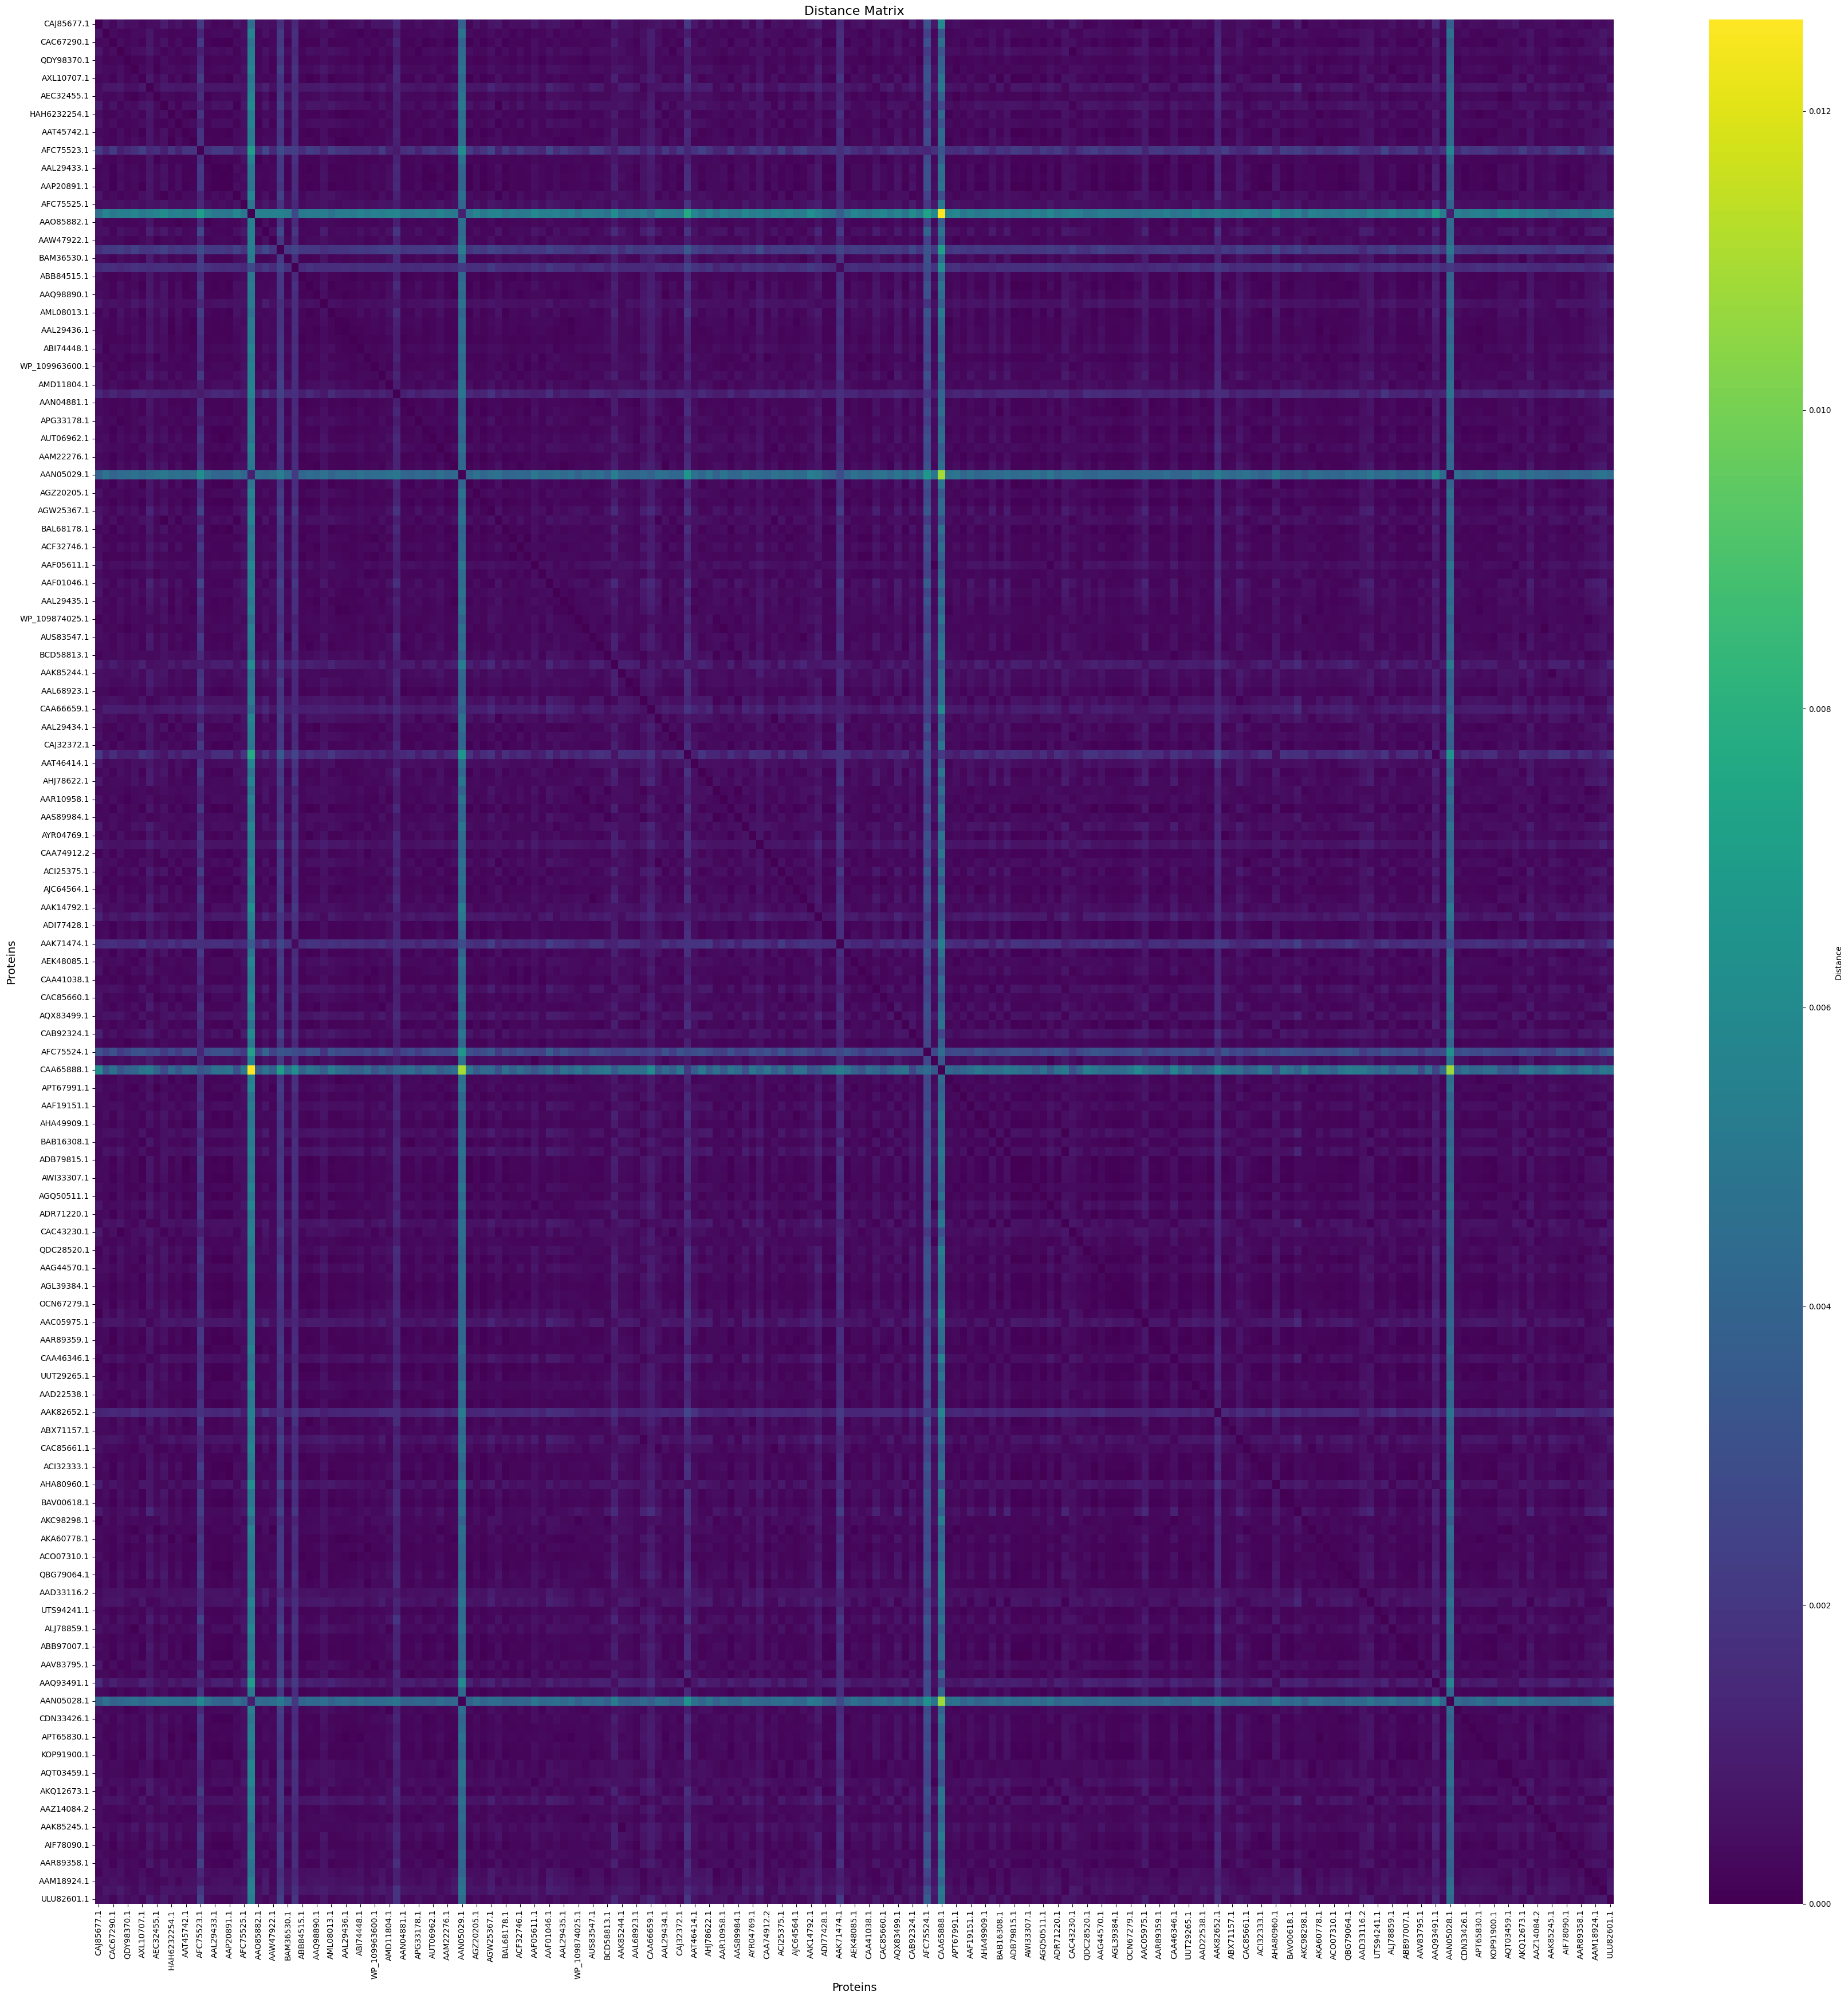

In [7]:
# Example data
proteins = protein_ids_embedding
distances = distance_matrix_embeddings_cosine

# Convert the distance array to a DataFrame for better labeling
distance_df = pd.DataFrame(distances, index=proteins, columns=proteins)

# Plot the heatmap
plt.figure(figsize=(35, 35))
sns.heatmap(
    distance_df, 
    annot=False,
    fmt=".2f",           
    cmap="viridis",      
    cbar_kws={'label': 'Distance'},
    annot_kws={"size": 2},
)

# Add titles and labels
plt.title("Distance Matrix", fontsize=16)
plt.xlabel("Proteins", fontsize=14)
plt.ylabel("Proteins", fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

In [8]:
# get me the 10 most unsimilar proteins
# Get the upper triangle of the distance matrix (excluding diagonal)
upper_triangle = np.triu(distances, k=1)

# Get indices of the 10 largest distances
max_indices = np.unravel_index(np.argsort(upper_triangle.ravel())[-10:], upper_triangle.shape)

# Create a list of protein pairs and their distances
dissimilar_pairs = []
for i, j in zip(max_indices[0], max_indices[1]):
    if i < j:  # Only take pairs from upper triangle
        dissimilar_pairs.append((proteins[i], proteins[j], distances[i,j]))

# Sort by distance in descending order
dissimilar_pairs.sort(key=lambda x: x[2], reverse=True)

# Print the results
print("\n10 Most Dissimilar Protein Pairs:")
print("Protein 1\tProtein 2\tDistance")
print("-" * 50)
for p1, p2, dist in dissimilar_pairs:
    print(f"{p1}\t{p2}\t{dist:.4f}")




10 Most Dissimilar Protein Pairs:
Protein 1	Protein 2	Distance
--------------------------------------------------
AEQ59620.1	CAA65888.1	0.0126
AAN05029.1	CAA65888.1	0.0109
CAA65888.1	AAN05028.1	0.0107
AEQ59620.1	AAQ93490.1	0.0077
AEQ59620.1	AFC75524.1	0.0073
QPG87090.1	CAA65888.1	0.0071
AFC75523.1	AEQ59620.1	0.0071
AEQ59620.1	AAQ93491.1	0.0070
AAN05029.1	AFC75524.1	0.0067
AAN05029.1	AAQ93490.1	0.0066


In [9]:
# now the same thing as above but the n most unsimular proteins on average over all other proteins
# Calculate mean distance for each protein to all other proteins
mean_distances = np.mean(distances, axis=1)

# Get indices of proteins sorted by mean distance (descending)
sorted_indices = np.argsort(mean_distances)[::-1]

# Get top 10 most dissimilar proteins
top_10_dissimilar = sorted_indices[:10]

# Create list of proteins and their mean distances
dissimilar_proteins = [(proteins[i], mean_distances[i]) for i in top_10_dissimilar]

dissimilary_score = [(proteins[i], mean_distances[i]) for i in sorted_indices]

# Print the results
print("\n10 Most Dissimilar Proteins (by average distance):")
print("Protein\tMean Distance")
print("-" * 40)
for protein, mean_dist in dissimilar_proteins:
    print(f"{protein}\t{mean_dist:.4f}")



10 Most Dissimilar Proteins (by average distance):
Protein	Mean Distance
----------------------------------------
AEQ59620.1	0.0053
CAA65888.1	0.0044
AAN05029.1	0.0044
AAN05028.1	0.0043
AFC75524.1	0.0028
QPG87090.1	0.0022
AFC75523.1	0.0018
AAD45935.1	0.0017
AAK71474.1	0.0016
AAQ93490.1	0.0015


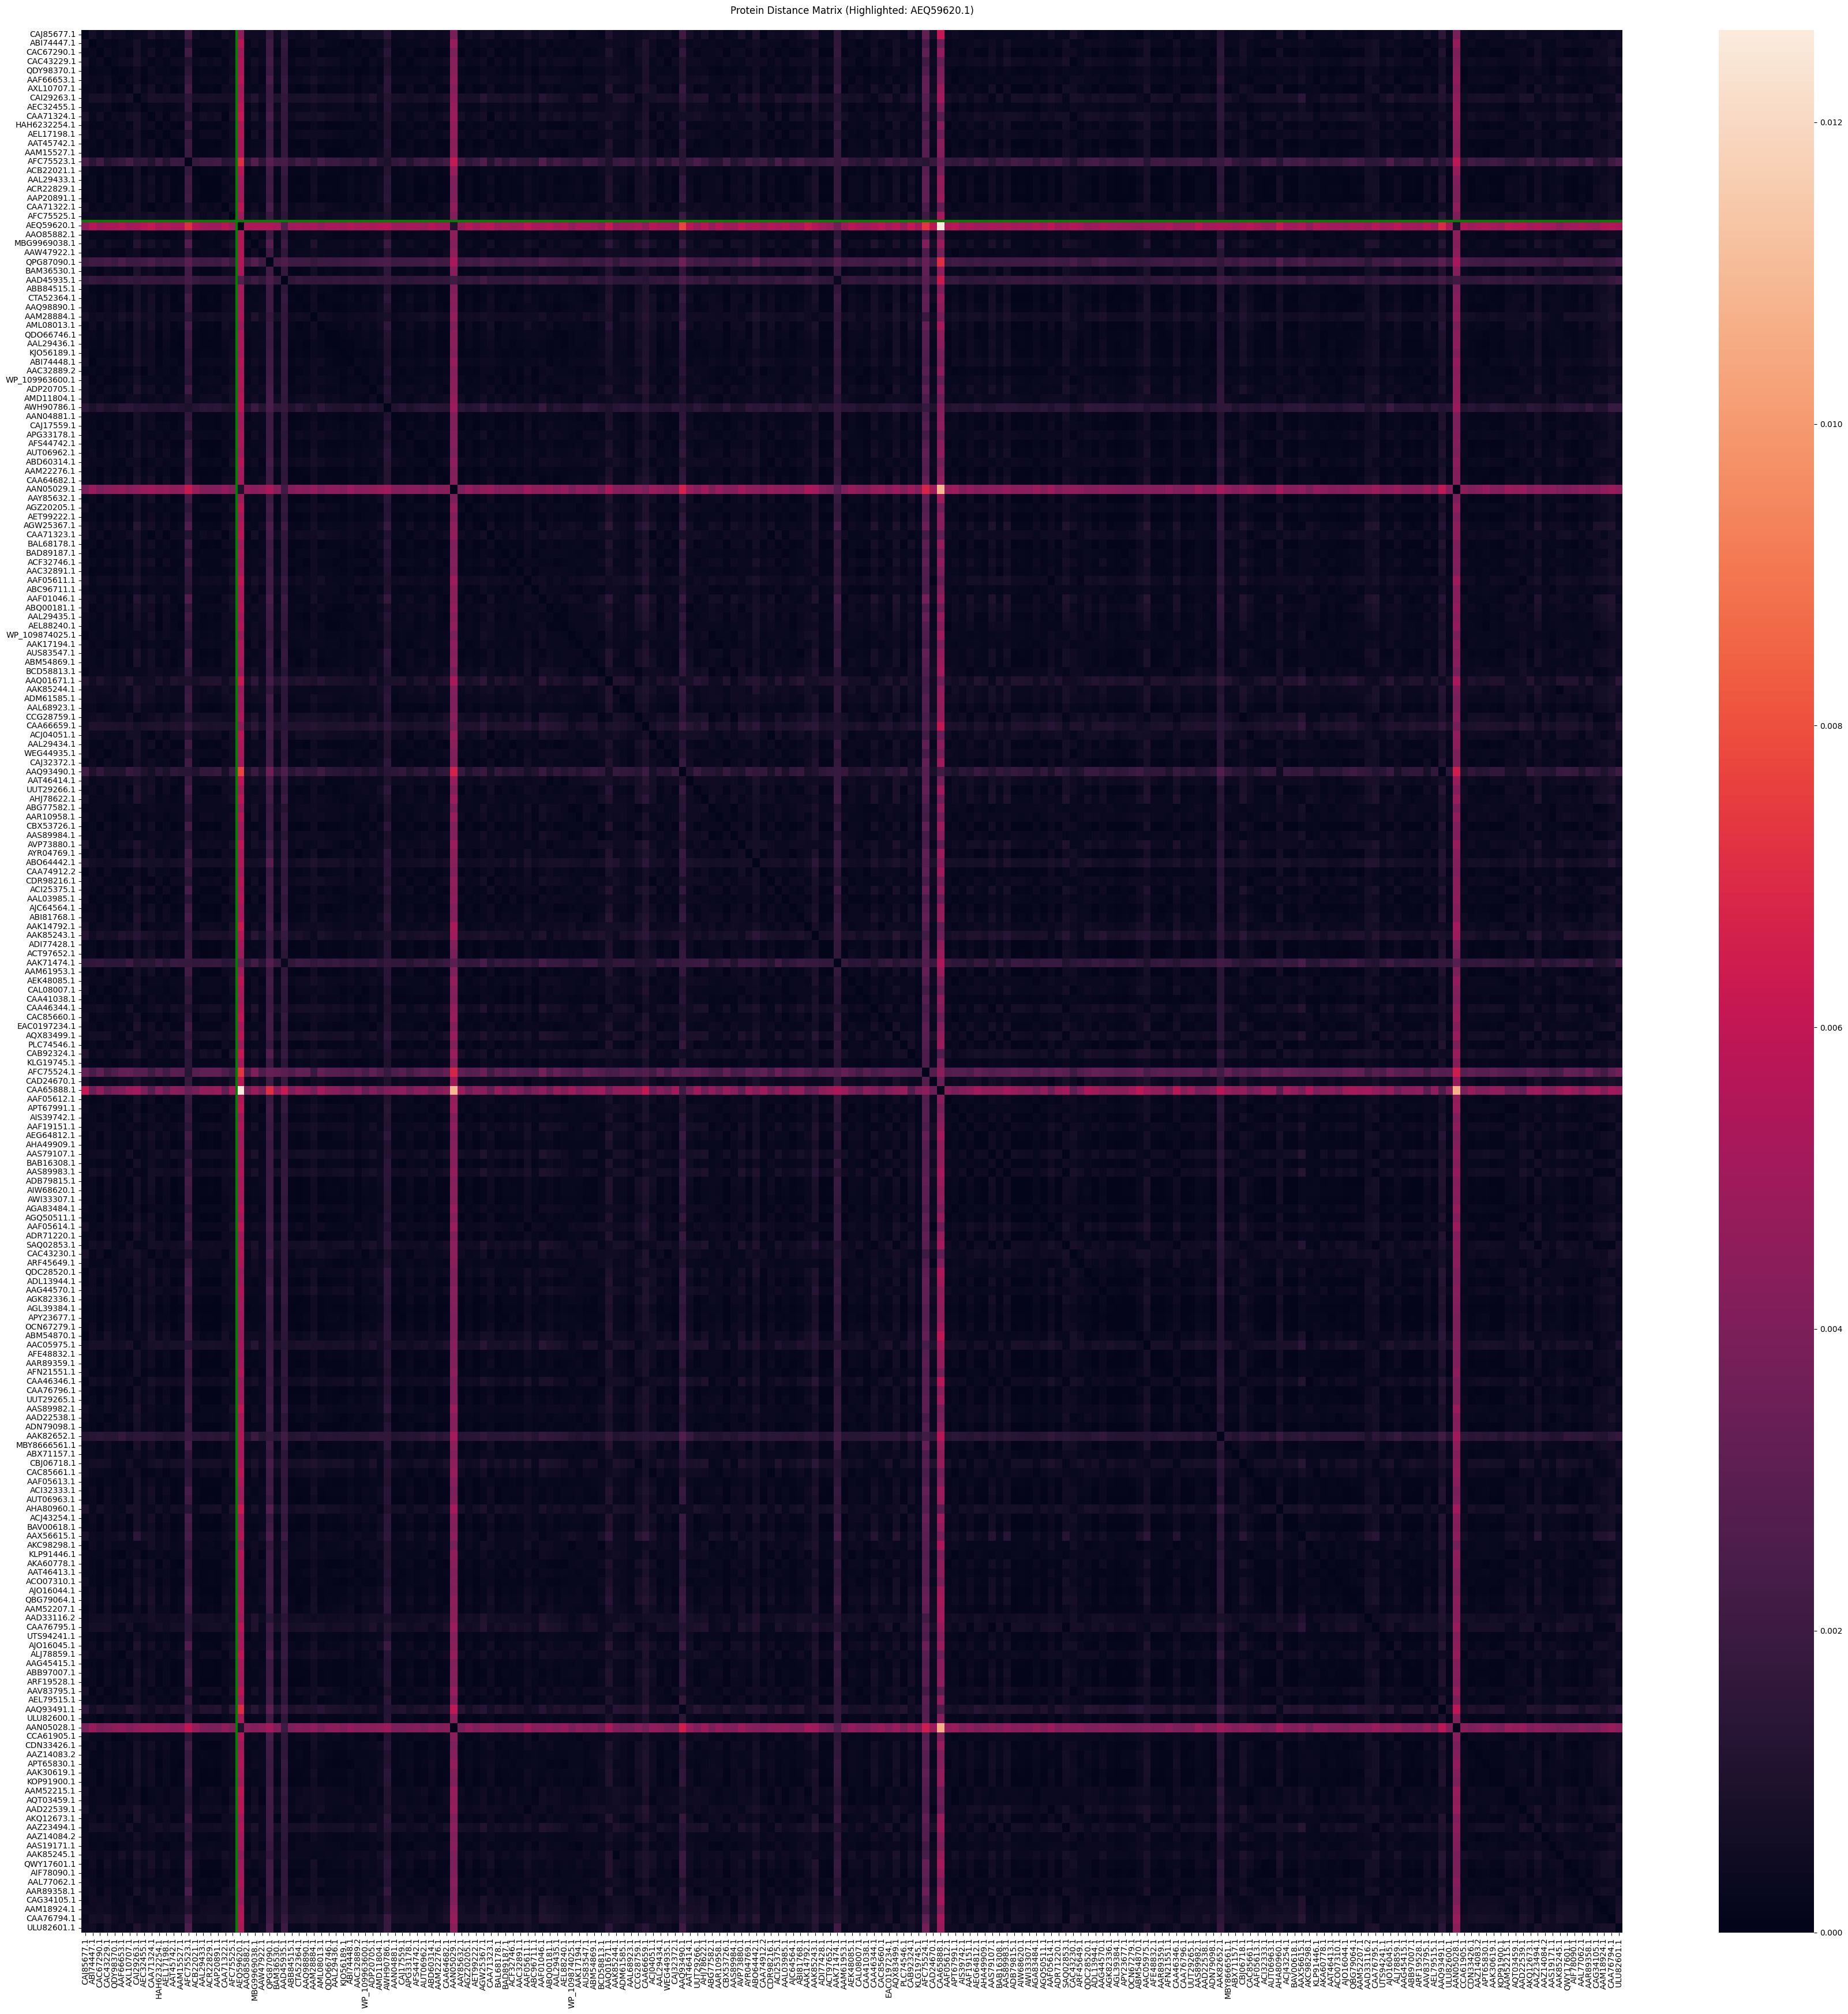

In [10]:
# plot the same matrix again but highlight the follwoing row with a special label so i can find them
# AEQ59620.1

# Create a new figure with a larger size
plt.figure(figsize=(35, 35))

# Create the heatmap
sns.heatmap(distances, xticklabels=proteins, yticklabels=proteins)

# Find the index of AEQ59620.1
highlight_protein = 'AEQ59620.1'
# protein ist just a list of strings
highlight_idx = proteins.tolist().index(highlight_protein)

# Highlight the row and column
plt.axhline(y=highlight_idx, color='green', linewidth=3)
plt.axvline(x=highlight_idx, color='green', linewidth=3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Add a title
plt.title('Protein Distance Matrix (Highlighted: AEQ59620.1)', pad=20)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
# group the dissimilary score into 10 groups and give them as a lable their group number
# split the dissimiliatry score in two categories but do it based on the mean distance
# meaning do not just make the half of the proteins into one group and the other half into another group
# but make it based on the mean distance
# make it so i can determine the number of groups i want to make
# Get mean distance for each protein
mean_distances = np.mean(distances, axis=1)
from sklearn.cluster import KMeans
# Number of groups to create
n_groups = 4  # This is the number of groups we want to make

# Use KMeans clustering on the mean distances
kmeans = KMeans(n_clusters=n_groups, random_state=42)
# Reshape mean_distances to 2D array as required by KMeans
clusters = kmeans.fit_predict(mean_distances.reshape(-1, 1))

# Create empty lists to store proteins for each group
dissimilary_score_groups = [[] for _ in range(n_groups)]
dissimilary_score_groups_labels = [f"Group_{i+1}" for i in range(n_groups)]

# Assign proteins to their respective groups
for i, (protein, cluster) in enumerate(zip(proteins, clusters)):
    # Store tuple of (protein_id, mean_distance) in appropriate group
    dissimilary_score_groups[cluster].append((protein, mean_distances[i]))

# Sort proteins within each group by their mean distance
for group in dissimilary_score_groups:
    group.sort(key=lambda x: x[1])



# now add them to the dict_id_label
for i in range(len(dissimilary_score_groups)):
    for protein in dissimilary_score_groups[i]:
        dict_id_label[protein[0]] = dissimilary_score_groups_labels[i]


In [12]:
embedding_tool = EmbeddingTool()

# get all of the data from embedding
protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label, perplexity=8, n_iter=3000, random_state=42)

print(f"Number of proteins in visualization: {len(protein_ids)}")

# make the None objects to 'None' in labels
labels = ['None' if x is None else x for x in labels]

# create a scatter plot for each unique label
unique_labels = set(labels)
unique_color_labels = {}
print(unique_labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k",
    )
    
    # store the color for the label
    unique_color_labels[label] = colors[indices[0]]

print(unique_color_labels)

plt.title("2D t-SNE Visualization of Protein Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'EmbeddingTool' is not defined

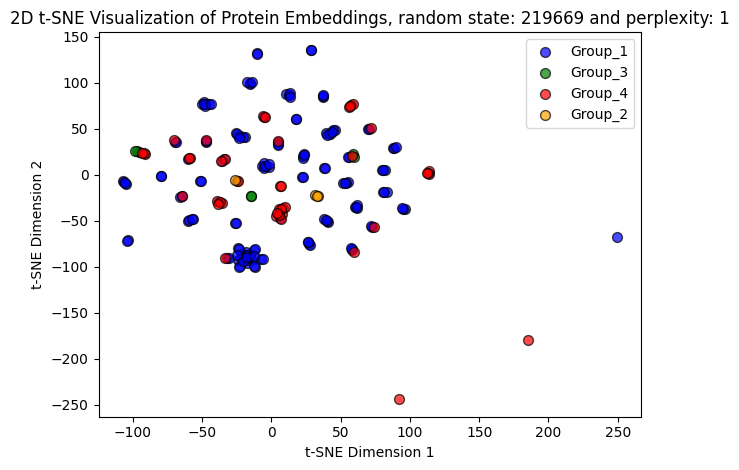

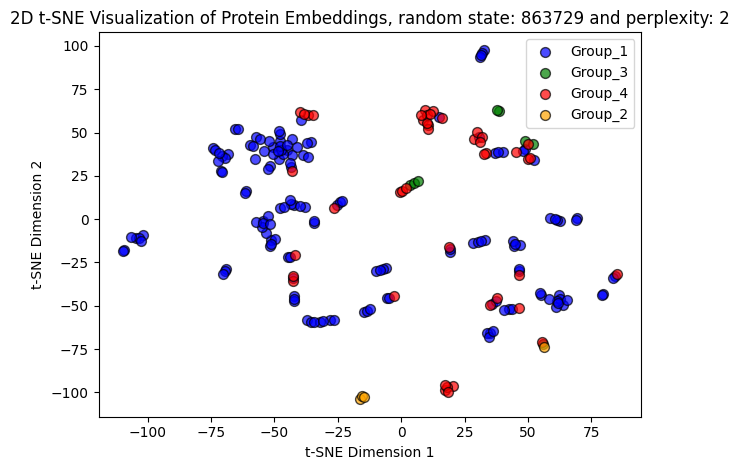

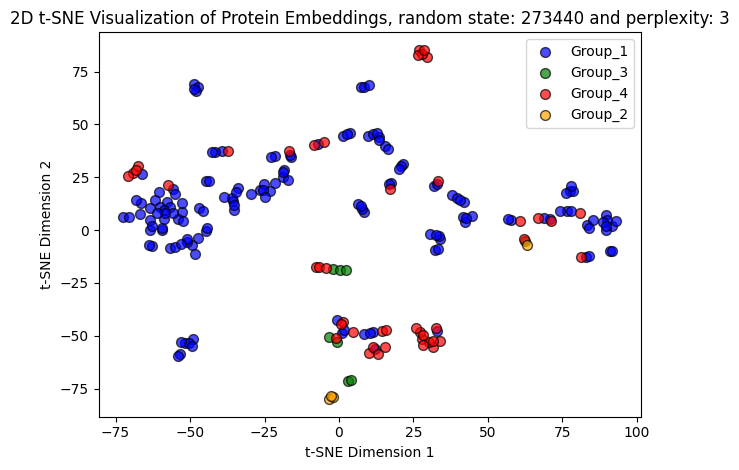

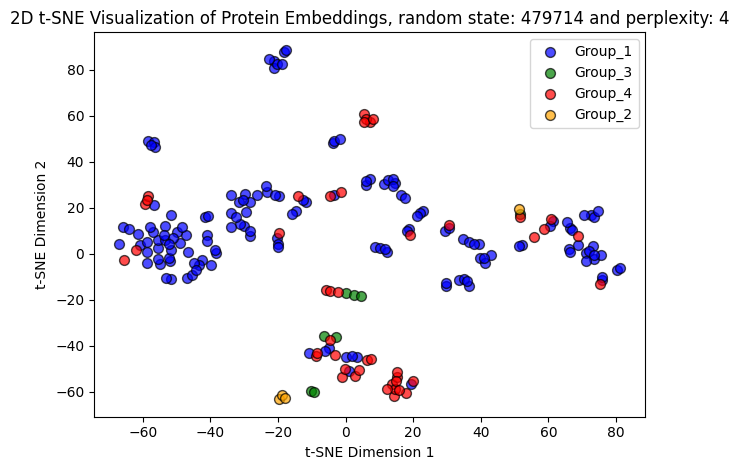

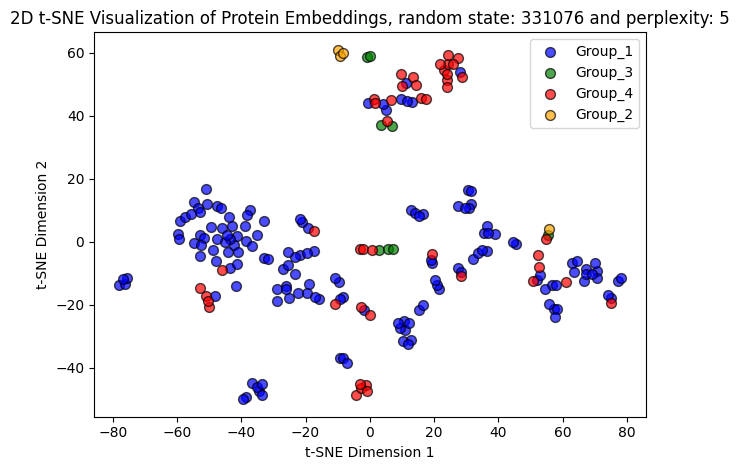

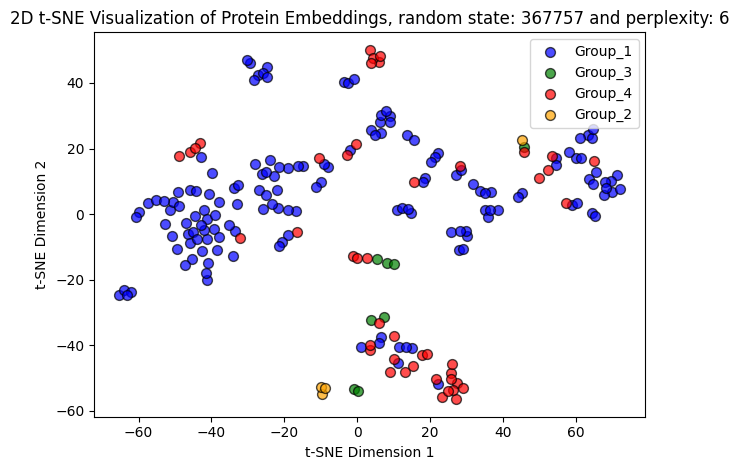

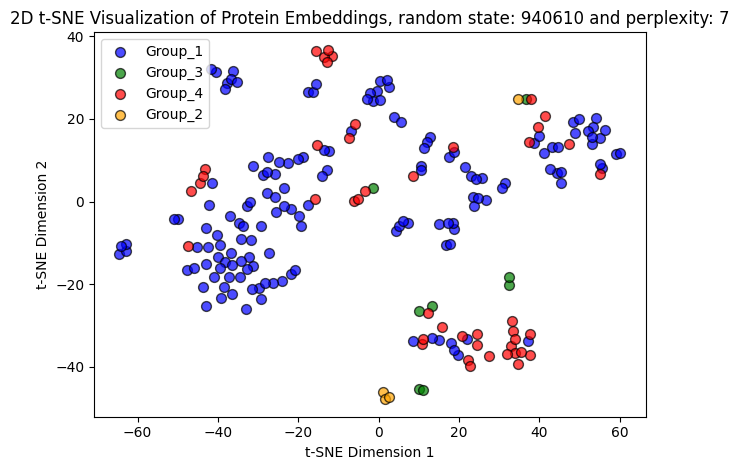

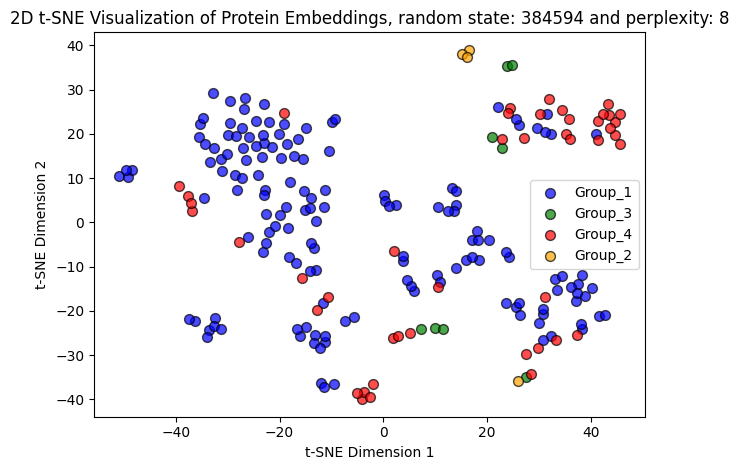

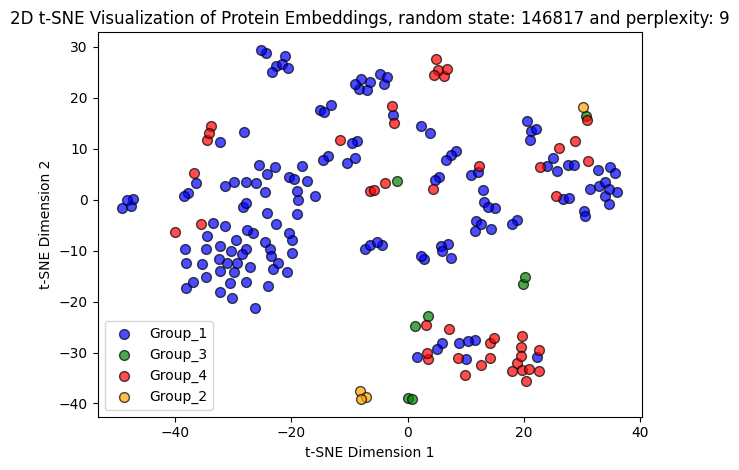

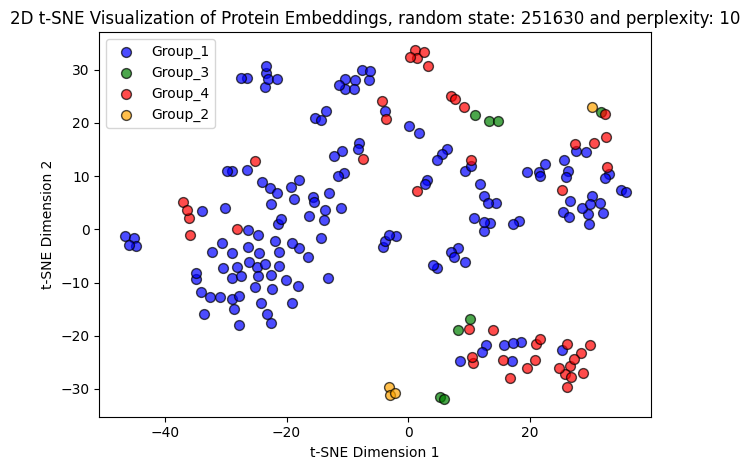

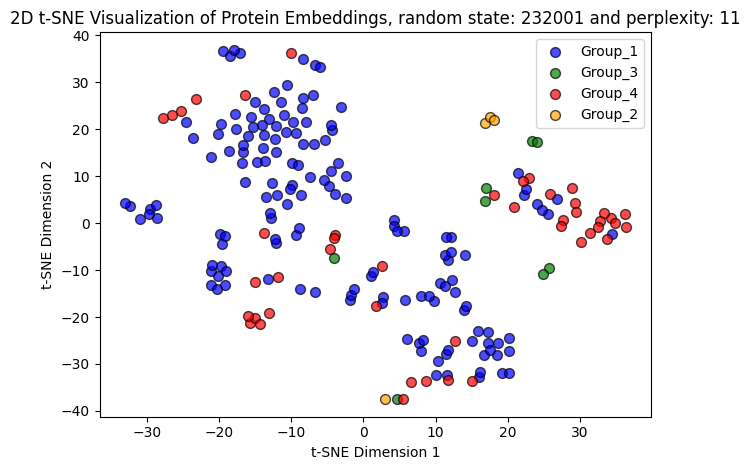

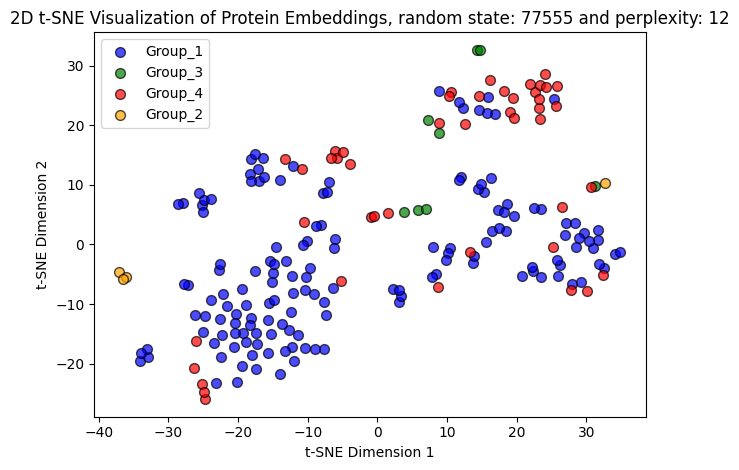

In [61]:
import random

for i in range(12):
    # do the same thing as above but with a different random state
    random_state = random.randint(1000, 1000000)
    protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label, perplexity=i+1, n_iter=3000, random_state=random_state)

    # plot
    # make the None objects to 'None' in labels
    labels = ['None' if x is None else x for x in labels]

    # create a scatter plot for each unique label
    unique_labels = set(labels)
    unique_color_labels = {}
    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(
            [embeddings_2d[i, 0] for i in indices],
            [embeddings_2d[i, 1] for i in indices],
            c=[colors[indices[0]]],
            label=label,
            alpha=0.7,
            s=50,
            edgecolor="k",
        )
        
        # store the color for the label
        unique_color_labels[label] = colors[indices[0]]


    plt.title(f"2D t-SNE Visualization of Protein Embeddings, random state: {random_state} and perplexity: {i+1}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

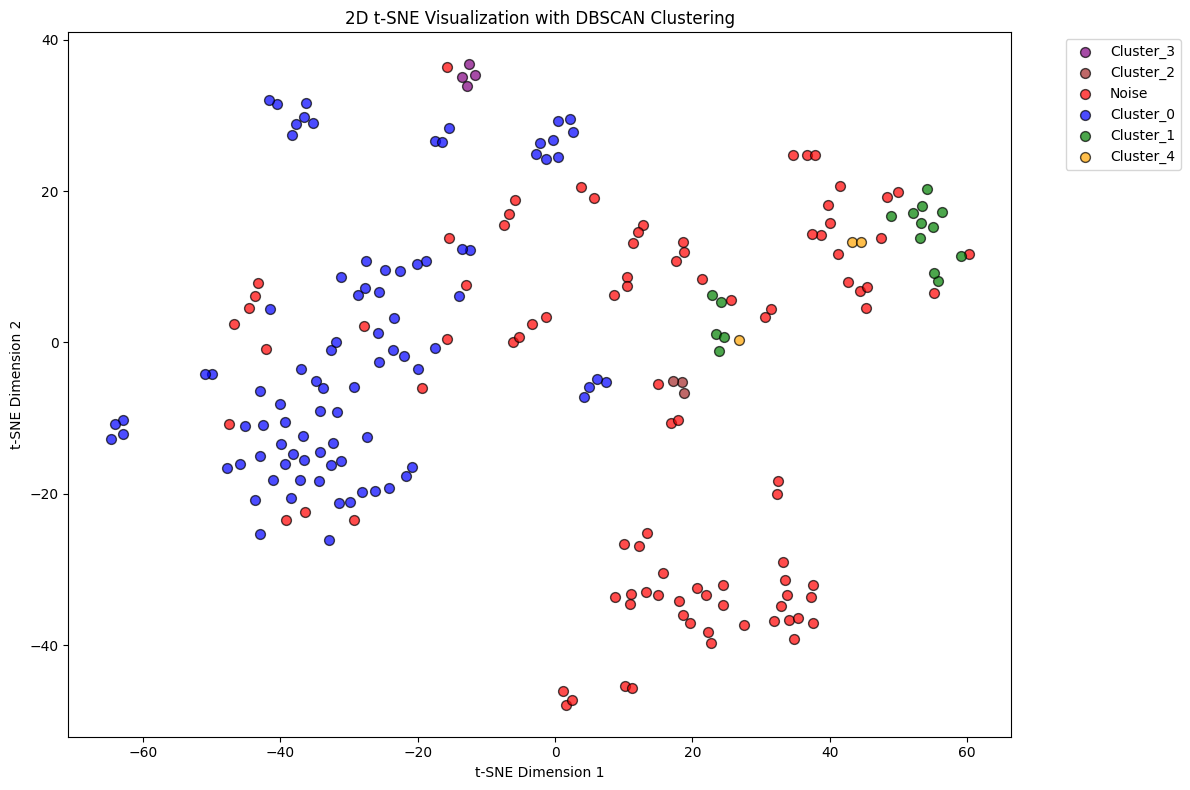


Cluster Statistics:
Noise        95
Cluster_0    88
Cluster_1    16
Cluster_3     4
Cluster_4     3
Cluster_2     3
Name: count, dtype: int64


In [77]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize the distances for better DBSCAN performance
scaler = StandardScaler()
distances_scaled = scaler.fit_transform(distances)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.4, min_samples=3)  # You may need to adjust these parameters
clusters = dbscan.fit_predict(distances_scaled)

# Create a new dictionary mapping protein IDs to cluster labels
dict_id_label = {}
for protein_id, cluster in zip(proteins, clusters):
    dict_id_label[protein_id] = f"Cluster_{cluster}" if cluster != -1 else "Noise"

# Calculate t-SNE projection with the new cluster labels
protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(
    db=eedb.db, 
    ids_list=ids, 
    ids_list_labels=dict_id_label, 
    perplexity=7, 
    n_iter=3000, 
    random_state=42
)

# Create the visualization
plt.figure(figsize=(12, 8))

# Convert None to 'None' in labels
labels = ['None' if x is None else x for x in labels]

# Plot each cluster
unique_labels = set(labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k",
    )

plt.title("2D t-SNE Visualization with DBSCAN Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print cluster statistics
cluster_counts = pd.Series(labels).value_counts()
print("\nCluster Statistics:")
print(cluster_counts)

In [80]:
# Get sequences for all proteins
sequences = []
for protein_id in ids:
    # Query the database for the sequence
    query = f"""
    MATCH (p:Protein {{accession_id: $protein_id}})
    RETURN p.sequence as sequence
    """
    result = eedb.db.execute_read(query, {"protein_id": protein_id})
    sequence = result[0]['sequence'] if result else None
    if sequence:
        sequences.append((protein_id, sequence))

# Write to FASTA file
output_path = '/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_proteins.fasta'
with open(output_path, 'w') as f:
    for protein_id, sequence in sequences:
        f.write(f'>{protein_id}\n')
        # Write sequence with line breaks every 60 characters
        for i in range(0, len(sequence), 60):
            f.write(sequence[i:i+60] + '\n')

print(f"Written {len(sequences)} sequences to {output_path}")

Written 209 sequences to /home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_proteins.fasta


In [14]:
from sklearn.decomposition import PCA

# Create PCA object
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization

# Fit and transform the distance matrix
# Using the cosine distance matrix, but you could also use euclidean or mutations
pca_result = pca.fit_transform(distance_matrix_embeddings_cosine)

# Create the visualization
plt.figure(figsize=(12, 8))

# Create scatter plot
for label in set(labels):
    mask = np.array(labels) == label
    plt.scatter(
        pca_result[mask, 0],
        pca_result[mask, 1],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k"
    )

plt.title("PCA of Protein Distances")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print explained variance ratio
print("\nExplained variance ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total: {sum(pca.explained_variance_ratio_[:2]):.2%}")

IndexError: boolean index did not match indexed array along axis 0; size of axis is 209 but size of corresponding boolean axis is 265

<Figure size 1200x800 with 0 Axes>

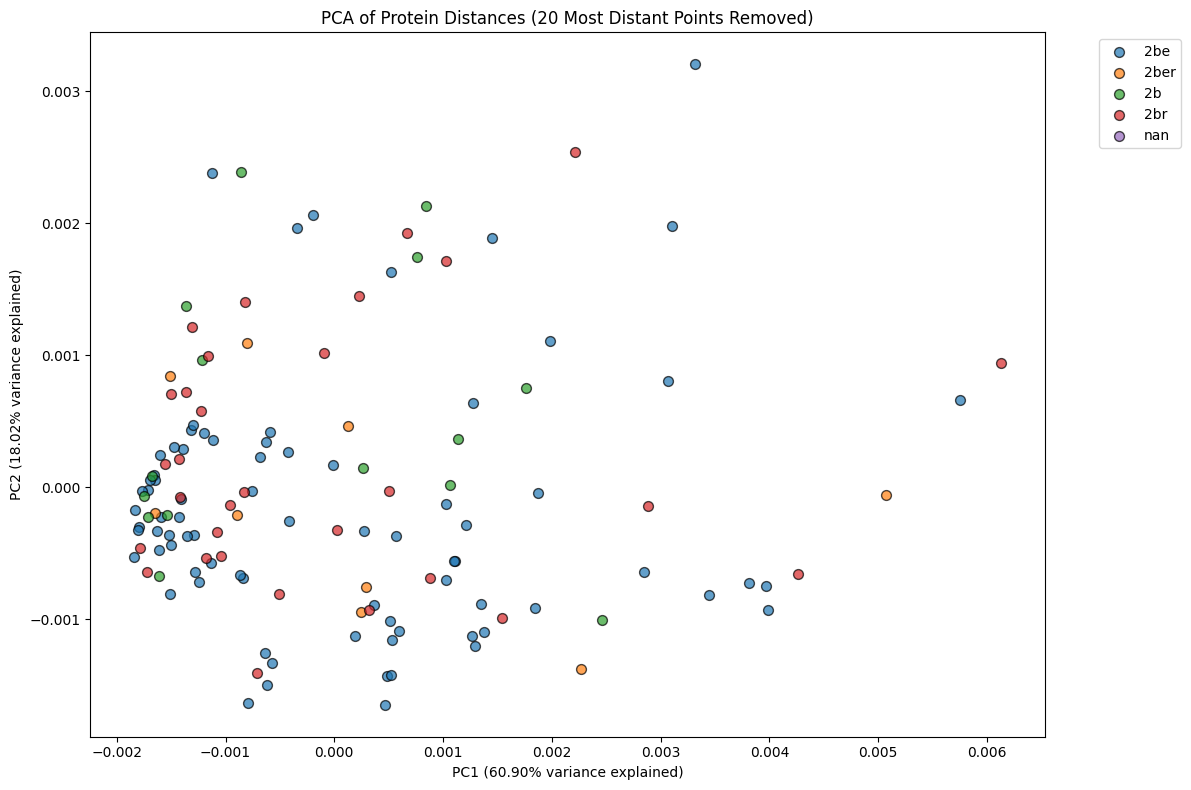


Explained variance ratio (after removing 20 most distant points):
PC1: 60.90%
PC2: 18.02%
Total: 78.92%


In [16]:
# can you remove the 20 most far away proteins from the PCA plot and then do it again
# Calculate distances from origin for each point
distances_from_origin = np.sqrt(pca_result[:,0]**2 + pca_result[:,1]**2)

# Get indices of points sorted by distance (excluding the 20 farthest)
n_to_remove = 20
kept_indices = np.argsort(distances_from_origin)[:-n_to_remove]

# Filter the data
filtered_distance_matrix = distance_matrix_embeddings_cosine[kept_indices][:,kept_indices]
filtered_phenotypes = np.array(df['phenotype'])[kept_indices]

# Perform PCA on filtered data
pca_filtered = PCA(n_components=2)
pca_filtered_result = pca_filtered.fit_transform(filtered_distance_matrix)

# Create visualization
plt.figure(figsize=(12, 8))

# Create scatter plot
for label in set(filtered_phenotypes):
    mask = filtered_phenotypes == label
    plt.scatter(
        pca_filtered_result[mask, 0],
        pca_filtered_result[mask, 1],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k"
    )

plt.title("PCA of Protein Distances (20 Most Distant Points Removed)")
plt.xlabel(f"PC1 ({pca_filtered.explained_variance_ratio_[0]:.2%} variance explained)")
plt.ylabel(f"PC2 ({pca_filtered.explained_variance_ratio_[1]:.2%} variance explained)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print explained variance ratio
print("\nExplained variance ratio (after removing 20 most distant points):")
print(f"PC1: {pca_filtered.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca_filtered.explained_variance_ratio_[1]:.2%}")
print(f"Total: {sum(pca_filtered.explained_variance_ratio_[:2]):.2%}")
